In [1]:
import warnings
warnings.filterwarnings('ignore')

# Combinando Python Notebooks con R y ggplot

## Cristian Cardellino - FaMAF

## Requisitos de Instalación

- [Anaconda](https://www.anaconda.com/) o [miniconda](https://conda.io/docs/user-guide/install/) environment con Python 3.
    - En su defecto el `scikit-learn` stack y `tzlocal`.

```
$ conda create --name meetupdscba python=3 anaconda tzlocal
$ source activate meetupdscba
```

- Instalación de los paquetes `r-essentials` de Anaconda y el paquete [`rpy2`](https://rpy2.readthedocs.io).
    - En su defecto los paquetes `r-ggplot2`, `r-tidyr` y `rpy2`.

```
(meetupdscba) $ conda install -c r r-tidyverse rpy2
```

- Clonar el repositorio del [tutorial](https://github.com/crscardellino/MeetupDSCba2017): 

```
git clone https://github.com/crscardellino/MeetupDSCba2017
```

## Requisitos de Datos

Como ejemplo de trabajo y visualización utilizaremos el clásico conjunto de datos de [supervivientes del Titanic](https://www.kaggle.com/c/titanic/) (se encuentra disponible dentro del directorio `./data` en el repositorio, por lo que no es necesario descargarlo).

## Importando Librerías

Empezamos por importar las dos librerías que utilizaremos al inicio de este tutorial: `pandas` y `rpy2`.

La librería `rpy` extiende la funcionalidad de los jupyter notebooks para poder utilizar la _cell magic_ `%%R`. Ésta convierte una celda en una terminal interactiva de **R**, persistente a través del notebook (i.e. las variables y funciones declaradas en una celda se pueden utilizar en otra celda).

In [2]:
import pandas as pd
import rpy2

# rpy2 utiliza como base la librería matplotlib, por lo que 
# para graficar dentro del notebook necesitamos declararlo
%matplotlib inline

# hay que activar la conversión automática para pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# cargamos la extensión para tener la cell magic %%R
%load_ext rpy2.ipython

In [3]:
%%R

library(ggplot2)
library(reshape2)

## Intercambiando dataframes entre Pandas y R

Con ayuda de `%%R`, se puede hacer un libre intercambio entre dataframes de Pandas y DataFrames de R. E.g. trabajar con pandas sobre ciertos datos, pasárselos a R para que haga ciertas operaciones y que R devuelva el resultado para seguir trabajándolo en Pandas.

In [4]:
# Cargamos el conjunto de datos del Titanic en un dataframe de pandas
titanic = pd.read_csv('./data/titanic.csv')

Podemos pasar el dataframe como variable de entrada a la celda `%%R` mediante el argumento `-i`. Por otro lado, se puede tomar un elemento (e.g. una variable) de la celda `%%R` y devolverlo a Python con el argumento `-o` (esto devuelve un vector, aunque sea de un solo elemento).

In [5]:
%%R -i titanic -o titanic_mean_fare

titanic_mean_fare <- mean(titanic$Fare)

In [6]:
print("Tarifa media de los pasajeros del Titanic: %.2f vs %.2f" % (titanic_mean_fare[0], titanic.Fare.mean()))

Tarifa media de los pasajeros del Titanic: 32.20 vs 32.20


## Introducción a ggplot

La librería `ggplot` de R es una librería que implementa _The Grammar of Graphics_ [1]. Para mayor información se recomienda leer [este tutorial](https://ramnathv.github.io/pycon2014-r/visualize/ggplot2.html). A grandes rasgos, las operaciones de visualización se definen como una suma de elementos. En particular hay dos elementos fundamentales:

- _Aesthetics_: Define las asociaciones entre los datos y diferentes elementos del gráfico. E.g. ejes de coordenadas, color, textura, forma, etc.
- _Geometries_: Es el que define que tipo de gráfico se visualizará. E.g. puntos, barras, líneas, etc.

La operación principal es `ggplot`, que toma el dataframe y algunos _aesthetics_. Y luego se suman las _geometries_.

### Scatter Plot (o bien Point Plot)

Si quisiéramos ver si hay algún tipo de correlación entre la edad y la tarifa que pagaron los pasajeros del Titanic podemos hacer uso de un _scatter plot_ (o gráfico de dispersión). Cuando trabajamos con gráficos se puede definir el tamaño con los parámetros: `-w` para el ancho, `-h` para el alto y `-u` para las unidades (`in`, `cm`, `mm` o `px`).

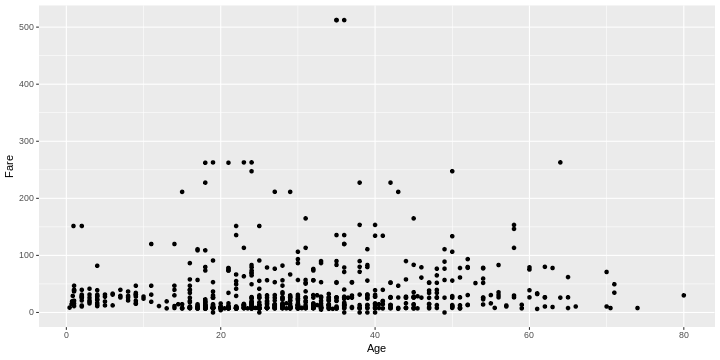

In [7]:
%%R -i titanic -w 10 -h 5 -u in

ggplot(titanic, aes(x=Age, y=Fare)) + geom_point()

### Bar Plot

Un gráfico de barras es útil para ver cantidades. Si quisiéramos ver la cantidad de hombres y mujeres es sencillo. El mismo `ggplot` se encarga de contar.

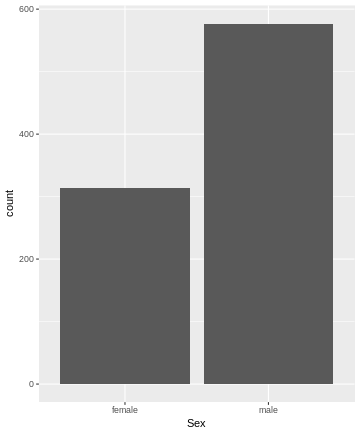

In [9]:
%%R -i titanic -w 5 -h 6 -u in

ggplot(titanic, aes(x=Sex)) + geom_bar()

## Gráficos avanzados

Por supuesto, `ggplot` logra hacer cosas mucho más complejas que las mostradas. Esto incluye gráficos superpuestos, uso de colores (u otros _aesthetics_), etc. Para lo primero basta con sumar nuevas _geometries_. Para lo segundo es necesario definir las _aesthetics_ a considerar.

Por otra parte, no sólo hay gráficos grises. Colorear los gráficos es tan sencillo como definir un aesthetic más. Además, existen muchas opciones para mejorar el gráfico.

### Distribución de población

Si quisiéramos ver la distribución de la población por edad podemos utilizar un histograma, un gráfico de densidad o ambos (por supuesto, normalizando el histograma).

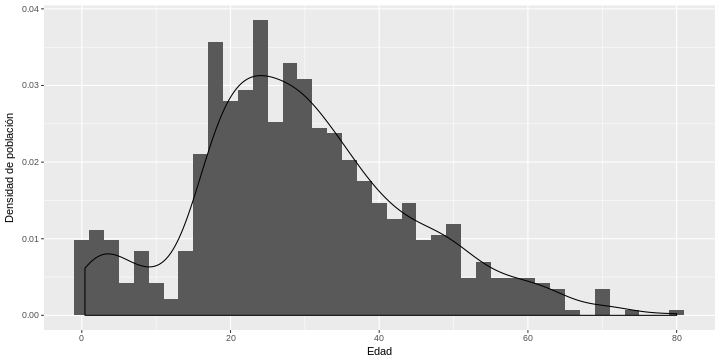

In [10]:
%%R -i titanic -w 10 -h 5 -u in

ggplot(titanic, aes(x=Age)) + geom_histogram(binwidth=2, aes(y = ..density..)) +
 geom_density() + labs(x='Edad', y='Densidad de población')

### Agregando más _aesthetics_

¿Qué tal si quisiéramos ver el gráfico de densidad anterior (sin el histograma) distinguido por sexo?

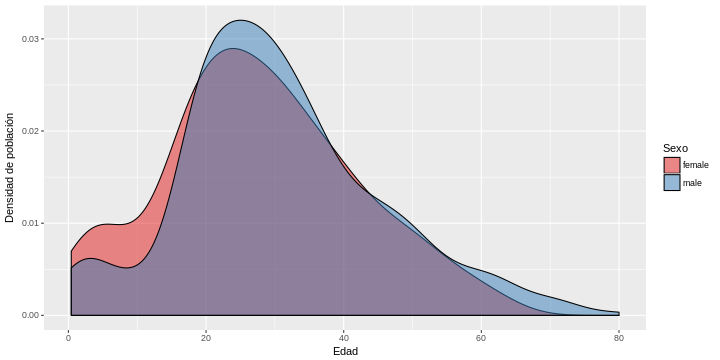

In [11]:
%%R -i titanic -w 10 -h 5 -u in

ggplot(titanic, aes(x=Age, fill=Sex)) + geom_density(alpha=0.5) +
 labs(x='Edad', y='Densidad de población') + 
 scale_fill_brewer(palette='Set1', name='Sexo')

### Agregando más variables

¿Y si quisiéramos tanto el histograma como la función de densidad? Una opción es hacer algo similar a lo anterior, otra es separar los datos en dos subgráficos.

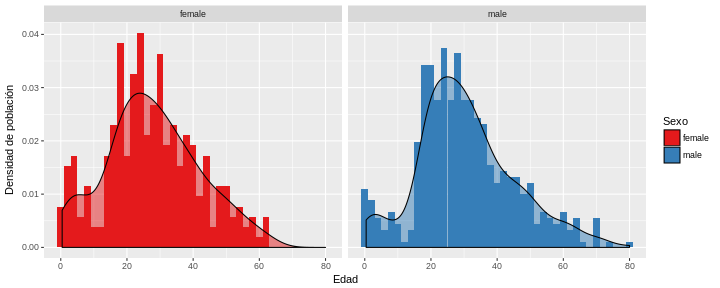

In [12]:
%%R -i titanic -w 10 -h 4 -u in

ggplot(titanic, aes(x=Age, fill=Sex)) + 
 geom_histogram(binwidth=2, aes(y = ..density..)) +
 geom_density(alpha=0.5) + labs(x='Edad', y='Densidad de población')+ 
 facet_wrap(~Sex) + scale_fill_brewer(palette='Set1', name='Sexo')

## Combinando el poder de Python con los gráficos de ggplot

Ya vimos como hacer distintos gráficos de `ggplot` en base al conjunto de datos del Titanic. Pero estos datos no fueron realmente utilizado en Pandas, simplemente los cargamos y se los pasamos a R para que haga el resto del trabajo. Hubiera sido lo mismo cargar los datos directamente en R.

Sin embargo, el poder de `rpy2` reside en la potencia que da para hacer trabajos en Python mientras se pueden interactuar con R y `ggplot` sin tener que cambiar el entorno.

Por ejemplo, supongamos que evaluar distintos clasificadores sobre el conjunto de datos del Titanic. 

### Haciendo uso de Scikit-Learn: Clasificadores y métricas

Si bien R tiene herramientas de aprendizaje automático, `scikit-learn` ofrece una serie de algoritmos y métricas muy sencillas de utilizar _out-of-the-box_. Vamos a evaluar 4 clasificadores y como es la performance sobre el conjunto de datos del Titanic.

In [13]:
# Clasificadores
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

# Métricas
from sklearn.metrics import precision_recall_fscore_support

# Utilidad para el preproceso de datos
from sklearn.model_selection import learning_curve, train_test_split
from scipy.stats import mode

### Preparando los datos

Para preparar los datos del Titanic para realizar una tarea de aprendizaje automático, seguimos los pasos básicos (Secciones 1-0, 1-1 y 1-2) del [Pycon UK Introductory Tutorial](https://github.com/savarin/pyconuk-introtutorial).

In [14]:
titanic = pd.read_csv('./data/titanic.csv')

# Eliminamos las columnas que no nos son de utilidad
titanic = titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# Llenamos las edades faltantes con el promedio
titanic['Age'] = titanic['Age'].fillna(titanic['Age'].mean())

# Asumimos que los puertos faltantes son el más 
mode_embarked = mode(titanic['Embarked'].fillna(''))[0][0]
titanic['Embarked'] = titanic['Embarked'].fillna(mode_embarked)

# Sexo es ahora 0 o 1
titanic['Sex'] = titanic['Sex'].map({'female': 0, 'male': 1}).astype(int) # Map sex with 

# Hacemos una "binarización" del atributo "Embarked" 
titanic = pd.concat([titanic, pd.get_dummies(titanic['Embarked'], prefix='Embarked')], axis=1)

# El atributo original ya no es necesario
titanic = titanic.drop(['Embarked'], axis=1)

### Entrenando y evaluando

Para evaluar los clasificadores primero dividimos el conjunto de datos en entrenamiento y evaluación. Por cada clasificador de los cuatro elegidos entrenamos con los datos de entrenamiento y evaluamos con los datos de evaluación. Guardamos toda la informació relevante en un dataframe de Pandas.

In [15]:
train_data, test_data, train_target, test_target =\
    train_test_split(titanic.iloc[:,1:], titanic.iloc[:,0])

results = []

for model in (LinearSVC, LogisticRegression, 
              DecisionTreeClassifier, RandomForestClassifier):
    clf = model()
    clf.fit(train_data, train_target)

    precision, recall, _, _ = precision_recall_fscore_support(test_target,
                              clf.predict(test_data))
    for survived in (0, 1):
        results.append({
            'classifier': model.__name__,
            'survived': survived,
            'precision': precision[survived],
            'recall': recall[survived]
        })
        
results = pd.DataFrame(results,
                       columns=['classifier', 'survived', 'precision', 'recall'])

### Graficando resultados: de formato ancho a formato largo.

Habiendo ya recolectado todos los resultados pasamos a graficar. Pero hay que tener en cuenta algo, estos resultados fueron guardados en lo que se conoce como _wide format_ (o formato ancho). En general, `ggplot` espera datos en _long format_ (o formato largo).

La diferencia fundamental está en que en _wide format_ los datos de un mismo sujeto (e.g. la performance del clasificador para las distintas métricas) están en una misma fila. Mientras que en _long format_ cada dato a graficar pertenece a una fila distinta.

Por suerte, R viene con la librería `reshape2` que tiene la función `melt`, que toma un dataframe en _wide format_ y lo convierte a _long format_ teniendo en cuenta algunas columnas que diferencian los datos a graficar (e.g. el tipo del clasificador y la etiqueta).

Para leer más acerca de la diferencia de _wide vs. long formats_ por favor referirse a [este link](http://www.theanalysisfactor.com/wide-and-long-data/).

Por otro lado, quizás querramos reorganizar la manera en que los resultados se muestran (e.g. para poner los algoritmos lineales al principio y los no lineales despues). R nos permite [hacer eso](https://www.r-bloggers.com/reorder-factor-levels/) a través de la función [`factor`](https://www.stat.berkeley.edu/classes/s133/factors.html).

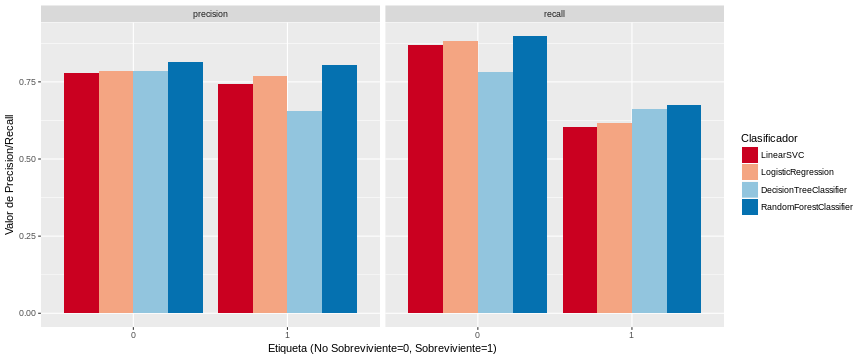

In [16]:
%%R -i results -w 12 -h 5 -u in

results <- melt(results, id.vars = c('classifier', 'survived'),
                variable.name = 'metric')

results$classifier <- factor(
    results$classifier,
    levels=c('LinearSVC', 'LogisticRegression',
             'DecisionTreeClassifier', 'RandomForestClassifier'))

ggplot(results, aes(x = factor(survived), y=value, fill=classifier)) +
    geom_bar(stat='identity', position='dodge') + facet_wrap(~metric) +
    labs(x="Etiqueta (No Sobreviviente=0, Sobreviviente=1)", y="Valor de Precision/Recall") +
    scale_fill_brewer(palette='RdBu', name='Clasificador')

### Un poco más de complejidad

Ya vimos como podíamos utilizar `ggplot` para visualizar las evaluaciones de los distintos conjuntos de datos. ¿Qué tal si queremos visualizar la curva de aprendizaje (_learning curve_) de los distintos algoritmos?

In [17]:
learning_curve_results = []

for model in (LinearSVC, LogisticRegression,
              DecisionTreeClassifier, RandomForestClassifier):
    train_sizes, train_scores, validation_scores = \
        learning_curve(model(), titanic.iloc[:,1:], titanic.iloc[:,1], cv=10)
    
    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    validation_scores_mean = validation_scores.mean(axis=1)
    validation_scores_std = validation_scores.std(axis=1)
    
    for iteration in range(train_sizes.shape[0]):
        learning_curve_results.append({
            'classifier': model.__name__,
            'data_size': train_sizes[iteration],
            'data_split': 'Entrenamiento',
            'score_mean': train_scores_mean[iteration],
            'score_std': train_scores_std[iteration]
        })
        
        learning_curve_results.append({
            'classifier': model.__name__,
            'data_size': train_sizes[iteration],
            'data_split': 'Validación',
            'score_mean': validation_scores_mean[iteration],
            'score_std': validation_scores_std[iteration]
        })
    
learning_curve_results = pd.DataFrame(learning_curve_results)

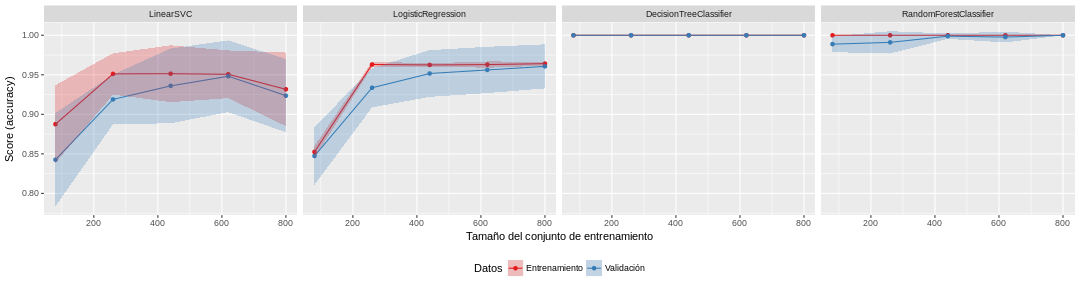

In [18]:
%%R -i learning_curve_results -w 15 -h 4 -u in

learning_curve_results$classifier <- factor(
    learning_curve_results$classifier,
    levels=c('LinearSVC', 'LogisticRegression',
             'DecisionTreeClassifier', 'RandomForestClassifier'))

ggplot(learning_curve_results, aes(x=data_size)) +
    geom_line(aes(y=score_mean, color=data_split)) +
    geom_point(aes(y=score_mean, color=data_split)) +
    geom_ribbon(aes(ymin=score_mean-score_std,
                    ymax=score_mean+score_std,
                    fill=data_split), alpha=0.25) +
    facet_wrap(~classifier, nrow=1) +
    theme(legend.position='bottom') +
    labs(x="Tamaño del conjunto de entrenamiento", y="Score (accuracy)") +
    scale_color_brewer(palette='Set1', name="Datos") +
    scale_fill_brewer(palette='Set1', name="Datos")

# ¿Preguntas?

# ¡Muchas gracias!

# Contacto

- Página personal: http://crscardellino.me
- Github: https://github.com/crscardellino
- Correo electrónico: [ccardellino@unc.edu.ar](mailto:ccardellino@unc.edu.ar)
- Link al material: http://crscardellino.me/work/#talks

## Referencias

[1] Wilkinson, Leland. The grammar of graphics. Springer Science & Business Media, 2006.